# Import Libraries

In [35]:
import pandas as pd
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import r2_score

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.base import BaseEstimator, RegressorMixin
import warnings
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xg 
from sklearn.multioutput import MultiOutputRegressor
import pickle
from tensorflow.keras.models import save_model, load_model

In [7]:
curr_dir_path = os.path.dirname(os.path.abspath('preprocessing.ipynb'))
processed_data_path = os.path.join(curr_dir_path, 'data/processed_data/')

# 1. Data Preparation
- Generate normalized SDOH subindex (0-100)
- Generate Candidate weighting schemes
- Combine weighted metrics into single SDOH subindex
- Scale final SDOH subindex to 0-100

## Load Dataset

In [8]:
main_df = pd.read_csv(os.path.join(processed_data_path, 'refined_merged_df.csv'))
main_df.head()

Median Income                              Name  Poverty 18-64  \
0          52112  Abbeville County, South Carolina       0.549803   
1          45266          Acadia Parish, Louisiana       0.579956   
2          57500         Accomack County, Virginia       0.533066   
3          88907                 Ada County, Idaho       0.585569   
4          88907                 Ada County, Idaho       0.585569   

   Unemployment  Lacking Complete Plumbing Facilities       65+  \
0      0.010880                              0.023115  0.225653   
1      0.033713                              0.016425  0.162608   
2      0.017023                              0.030038  0.252538   
3      0.015695                              0.001742  0.154124   
4      0.015695                              0.001742  0.154124   

   White Population  Percent Less Than High School Graduate  Uninsured  \
0          0.693135                                    17.5   0.993225   
1          0.780629                                    18.6   0.995594   
2          0.609804                                    10.1   0.988641   
3          0.829877                                     9.9   0.961168   
4          0.829877                                     9.9   0.961168   

   Percent With Internet  ...  PM10 24-hr (ug/m3)  Drinking Water Violations  \
0               0.313516  ...                 NaN                        1.0   
1               0.301741  ...                 NaN                        1.0   
2               0.356271  ...                 NaN                        1.0   
3               0.357881  ...                  61                        0.0   
4               0.357881  ...                  61                        0.0   

   RISK_SCORE Food Insecurity Heart Disease Mortality  \
0   38.689150           0.096                   354.9   
1   90.518613           0.160                   538.4   
2   89.564111           0.097                   421.9   
3   87.941457           0.069                   269.5   
4   87.941457           0.069                   269.5   

  Preventable Hospital Stays Poor or Fair Health State FIPS Code  \
0                     2519.0               0.200              45   
1                     3536.0               0.224              22   
2                     2002.0               0.205              51   
3                     1316.0               0.115              16   
4                     1316.0               0.115              16   

  County FIPS Code  5-digit FIPS Code  
0                1              45001  
1                1              22001  
2                1              51001  
3                1              16001  
4                1              16001  

[5 rows x 38 columns]

In [9]:
main_df.columns

Index(['Median Income', 'Name', 'Poverty 18-64', 'Unemployment',
       'Lacking Complete Plumbing Facilities', '65+', 'White Population',
       'Percent Less Than High School Graduate', 'Uninsured',
       'Percent With Internet', 'Long Commutes',
       'Some College or Associate's Degree', 'No Vehicle Available', 'GEO_ID',
       'State', 'Complete County Name', 'State Abbreviation',
       'Health Center Number', 'County Equivalent Name', 'HHS Region Code',
       'HHS Region Name', 'State FIPS and Congressional District Number Code',
       'Housing Cost Burden', 'Ratio of population to primary care physicians',
       'Mental Health Providers', 'Premature Mortality', 'Infant Mortality',
       'Total Population', 'PM10 24-hr (ug/m3)', 'Drinking Water Violations',
       'RISK_SCORE', 'Food Insecurity', 'Heart Disease Mortality',
       'Preventable Hospital Stays', 'Poor or Fair Health', 'State FIPS Code',
       'County FIPS Code', '5-digit FIPS Code'],
      dtype='object')

In [10]:
SDOH_variables = ['Median Income', 'Poverty 18-64', 'Unemployment', 'Lacking Complete Plumbing Facilities', '65+', 
                  'White Population', 'Percent Less Than High School Graduate', 
                  'Uninsured', 'Percent With Internet', 'Long Commutes', 'Some College or Associate\'s Degree', 
                  'No Vehicle Available', 'Housing Cost Burden', 'Ratio of population to primary care physicians',
                  'Mental Health Providers', 'PM10 24-hr (ug/m3)', 'Drinking Water Violations', 'Food Insecurity']

outcome_variables = ['Premature Mortality', 'Infant Mortality', 'Preventable Hospital Stays', 'Heart Disease Mortality', 'Poor or Fair Health']

primary_variables = ['Name', 'GEO_ID', 'State', 'Complete County Name', 'State Abbreviation', 'Health Center Number', 
                    'County Equivalent Name', 'HHS Region Code', 'HHS Region Name', 
                    'State FIPS and Congressional District Number Code']

SDOH_df = main_df[primary_variables + SDOH_variables]
outcome_df = main_df[primary_variables + outcome_variables]

## Preprocess and Normalize Dataset

In [11]:
missing_columns = [col for col in SDOH_variables if col not in SDOH_df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All columns are present.")

All columns are present.


In [12]:
print(SDOH_df.columns.duplicated().sum())
print(SDOH_df.columns[SDOH_df.columns.duplicated()])

0
Index([], dtype='object')


### Convert to Numeric

In [ ]:
for column in SDOH_variables:
    if column in SDOH_df.columns:
        print(f"Column '{column}' type: {type(SDOH_df[column])}")
        try:
            SDOH_df[column] = pd.to_numeric(SDOH_df[column], errors='coerce')
        except Exception as e:
            print(f"Error converting column {column}: {e}")

print(SDOH_df[SDOH_variables].isnull().sum())

Column 'Median Income' type: <class 'pandas.core.series.Series'>
Column 'Poverty 18-64' type: <class 'pandas.core.series.Series'>
Column 'Unemployment' type: <class 'pandas.core.series.Series'>
Column 'Lacking Complete Plumbing Facilities' type: <class 'pandas.core.series.Series'>
Column '65+' type: <class 'pandas.core.series.Series'>
Column 'White Population' type: <class 'pandas.core.series.Series'>
Column 'Percent Less Than High School Graduate' type: <class 'pandas.core.series.Series'>
Column 'Uninsured' type: <class 'pandas.core.series.Series'>
Column 'Percent With Internet' type: <class 'pandas.core.series.Series'>
Column 'Long Commutes' type: <class 'pandas.core.series.Series'>
Column 'Some College or Associate's Degree' type: <class 'pandas.core.series.Series'>
Column 'No Vehicle Available' type: <class 'pandas.core.series.Series'>
Column 'Housing Cost Burden' type: <class 'pandas.core.series.Series'>
Column 'Ratio of population to primary care physicians' type: <class 'pandas.

/tmp/ipykernel_1003152/1013896103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SDOH_df[column] = pd.to_numeric(SDOH_df[column], errors='coerce')


In [14]:
for column in outcome_variables:
    if column in outcome_df.columns:
        print(f"Column '{column}' type: {type(outcome_df[column])}")
        try:
            outcome_df[column] = pd.to_numeric(outcome_df[column], errors='coerce')
        except Exception as e:
            print(f"Error converting column {column}: {e}")

print(outcome_df[outcome_variables].isnull().sum())

Column 'Premature Mortality' type: <class 'pandas.core.series.Series'>
Column 'Infant Mortality' type: <class 'pandas.core.series.Series'>
Column 'Preventable Hospital Stays' type: <class 'pandas.core.series.Series'>
Column 'Heart Disease Mortality' type: <class 'pandas.core.series.Series'>
Column 'Poor or Fair Health' type: <class 'pandas.core.series.Series'>
Premature Mortality              5
Infant Mortality              1295
Preventable Hospital Stays      12
Heart Disease Mortality          0
Poor or Fair Health              0
dtype: int64


/tmp/ipykernel_1003152/2052149206.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df[column] = pd.to_numeric(outcome_df[column], errors='coerce')


### Handle Missing Values

In [ ]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
SDOH_inputed = iterative_imputer.fit_transform(SDOH_df[SDOH_variables])

SDOH_imputed_df = pd.DataFrame(SDOH_inputed, columns=SDOH_variables)

In [16]:
outcomes_inputed = iterative_imputer.fit_transform(outcome_df[outcome_variables])

outcome_imputed_df = pd.DataFrame(outcomes_inputed, columns=outcome_variables)

In [17]:
normalized_SDOH_df = SDOH_df.copy()
for column in SDOH_variables:
    # min-max normalization
    normalized_SDOH_df[column] = (SDOH_imputed_df[column] - SDOH_imputed_df[column].min()) / (SDOH_imputed_df[column].max() - SDOH_imputed_df[column].min())

    # reverse scale for metrics where higher is worse
    if column in ['Poverty 18-64', 'Unemployment', 'Lacking Complete Plumbing Facilities', 'Percent Less Than High School Graduate'
                  'Uninsured', 'Housing Cost Burden', 'Ratio of population to primary care physicians', 'PM10 24-hr (ug/m3)',
                  'Drinking Water Violations', 'Food Insecurity']:
        normalized_SDOH_df[column] = 1 - normalized_SDOH_df[column]

normalized_SDOH_df.head()


Name          GEO_ID           State  \
0  Abbeville County, South Carolina  0500000US45001  South Carolina   
1          Acadia Parish, Louisiana  0500000US22001       Louisiana   
2         Accomack County, Virginia  0500000US51001        Virginia   
3                 Ada County, Idaho  0500000US16001           Idaho   
4                 Ada County, Idaho  0500000US16001           Idaho   

  Complete County Name State Abbreviation Health Center Number  \
0     Abbeville County                 SC           H80CS00785   
1        Acadia Parish                 LA           H80CS00558   
2      Accomack County                 VA           H80CS00791   
3           Ada County                 ID           H80CS00636   
4           Ada County                 ID           H80CS26601   

  County Equivalent Name  HHS Region Code HHS Region Name  \
0              Abbeville                4        Region 4   
1                 Acadia                6        Region 6   
2               Accomack                3        Region 3   
3                    Ada               10       Region 10   
4                    Ada               10       Region 10   

   State FIPS and Congressional District Number Code  ...  \
0                                               4503  ...   
1                                               2203  ...   
2                                               5102  ...   
3                                               1602  ...   
4                                               1602  ...   

   Percent With Internet  Long Commutes  Some College or Associate's Degree  \
0               0.486236       0.118291                            0.539846   
1               0.452819       0.192528                            0.414653   
2               0.607574       0.080782                            0.402489   
3               0.612142       0.094677                            0.596292   
4               0.612142       0.094677                            0.596292   

   No Vehicle Available  Housing Cost Burden  \
0              0.060560             0.709709   
1              0.096370             0.695245   
2              0.078029             0.666852   
3              0.034922             0.704630   
4              0.034922             0.704630   

   Ratio of population to primary care physicians  Mental Health Providers  \
0                                        0.861426                 0.021622   
1                                        0.830041                 0.040199   
2                                        0.828488                 0.041494   
3                                        0.888524                 0.111460   
4                                        0.888524                 0.111460   

   PM10 24-hr (ug/m3)  Drinking Water Violations  Food Insecurity  
0            0.663274                        0.0         0.713004  
1            0.676205                        0.0         0.426009  
2            0.590885                        0.0         0.708520  
3            0.717559                        1.0         0.834081  
4            0.717559                        1.0         0.834081  

[5 rows x 28 columns]

### Generate subindex?

In [ ]:
normalized_SDOH_df['SDOH_subindex'] = normalized_SDOH_df[SDOH_variables].mean(axis=1)

normalized_SDOH_df['SDOH_subindex'] = normalized_SDOH_df['SDOH_subindex'] * 100

normalized_SDOH_df.head()

Name          GEO_ID           State  \
0  Abbeville County, South Carolina  0500000US45001  South Carolina   
1          Acadia Parish, Louisiana  0500000US22001       Louisiana   
2         Accomack County, Virginia  0500000US51001        Virginia   
3                 Ada County, Idaho  0500000US16001           Idaho   
4                 Ada County, Idaho  0500000US16001           Idaho   

  Complete County Name State Abbreviation Health Center Number  \
0     Abbeville County                 SC           H80CS00785   
1        Acadia Parish                 LA           H80CS00558   
2      Accomack County                 VA           H80CS00791   
3           Ada County                 ID           H80CS00636   
4           Ada County                 ID           H80CS26601   

  County Equivalent Name  HHS Region Code HHS Region Name  \
0              Abbeville                4        Region 4   
1                 Acadia                6        Region 6   
2               Accomack                3        Region 3   
3                    Ada               10       Region 10   
4                    Ada               10       Region 10   

   State FIPS and Congressional District Number Code  ...  Long Commutes  \
0                                               4503  ...       0.118291   
1                                               2203  ...       0.192528   
2                                               5102  ...       0.080782   
3                                               1602  ...       0.094677   
4                                               1602  ...       0.094677   

   Some College or Associate's Degree  No Vehicle Available  \
0                            0.539846              0.060560   
1                            0.414653              0.096370   
2                            0.402489              0.078029   
3                            0.596292              0.034922   
4                            0.596292              0.034922   

   Housing Cost Burden  Ratio of population to primary care physicians  \
0             0.709709                                        0.861426   
1             0.695245                                        0.830041   
2             0.666852                                        0.828488   
3             0.704630                                        0.888524   
4             0.704630                                        0.888524   

   Mental Health Providers  PM10 24-hr (ug/m3)  Drinking Water Violations  \
0                 0.021622            0.663274                        0.0   
1                 0.040199            0.676205                        0.0   
2                 0.041494            0.590885                        0.0   
3                 0.111460            0.717559                        1.0   
4                 0.111460            0.717559                        1.0   

   Food Insecurity  SDOH_subindex  
0         0.713004      47.126959  
1         0.426009      43.423294  
2         0.708520      45.349389  
3         0.834081      55.377400  
4         0.834081      55.377400  

[5 rows x 29 columns]

In [19]:
normalized_SDOH_df.drop(primary_variables, axis=1).shape

(3907, 19)

## Pairplot and Correlation Matrix

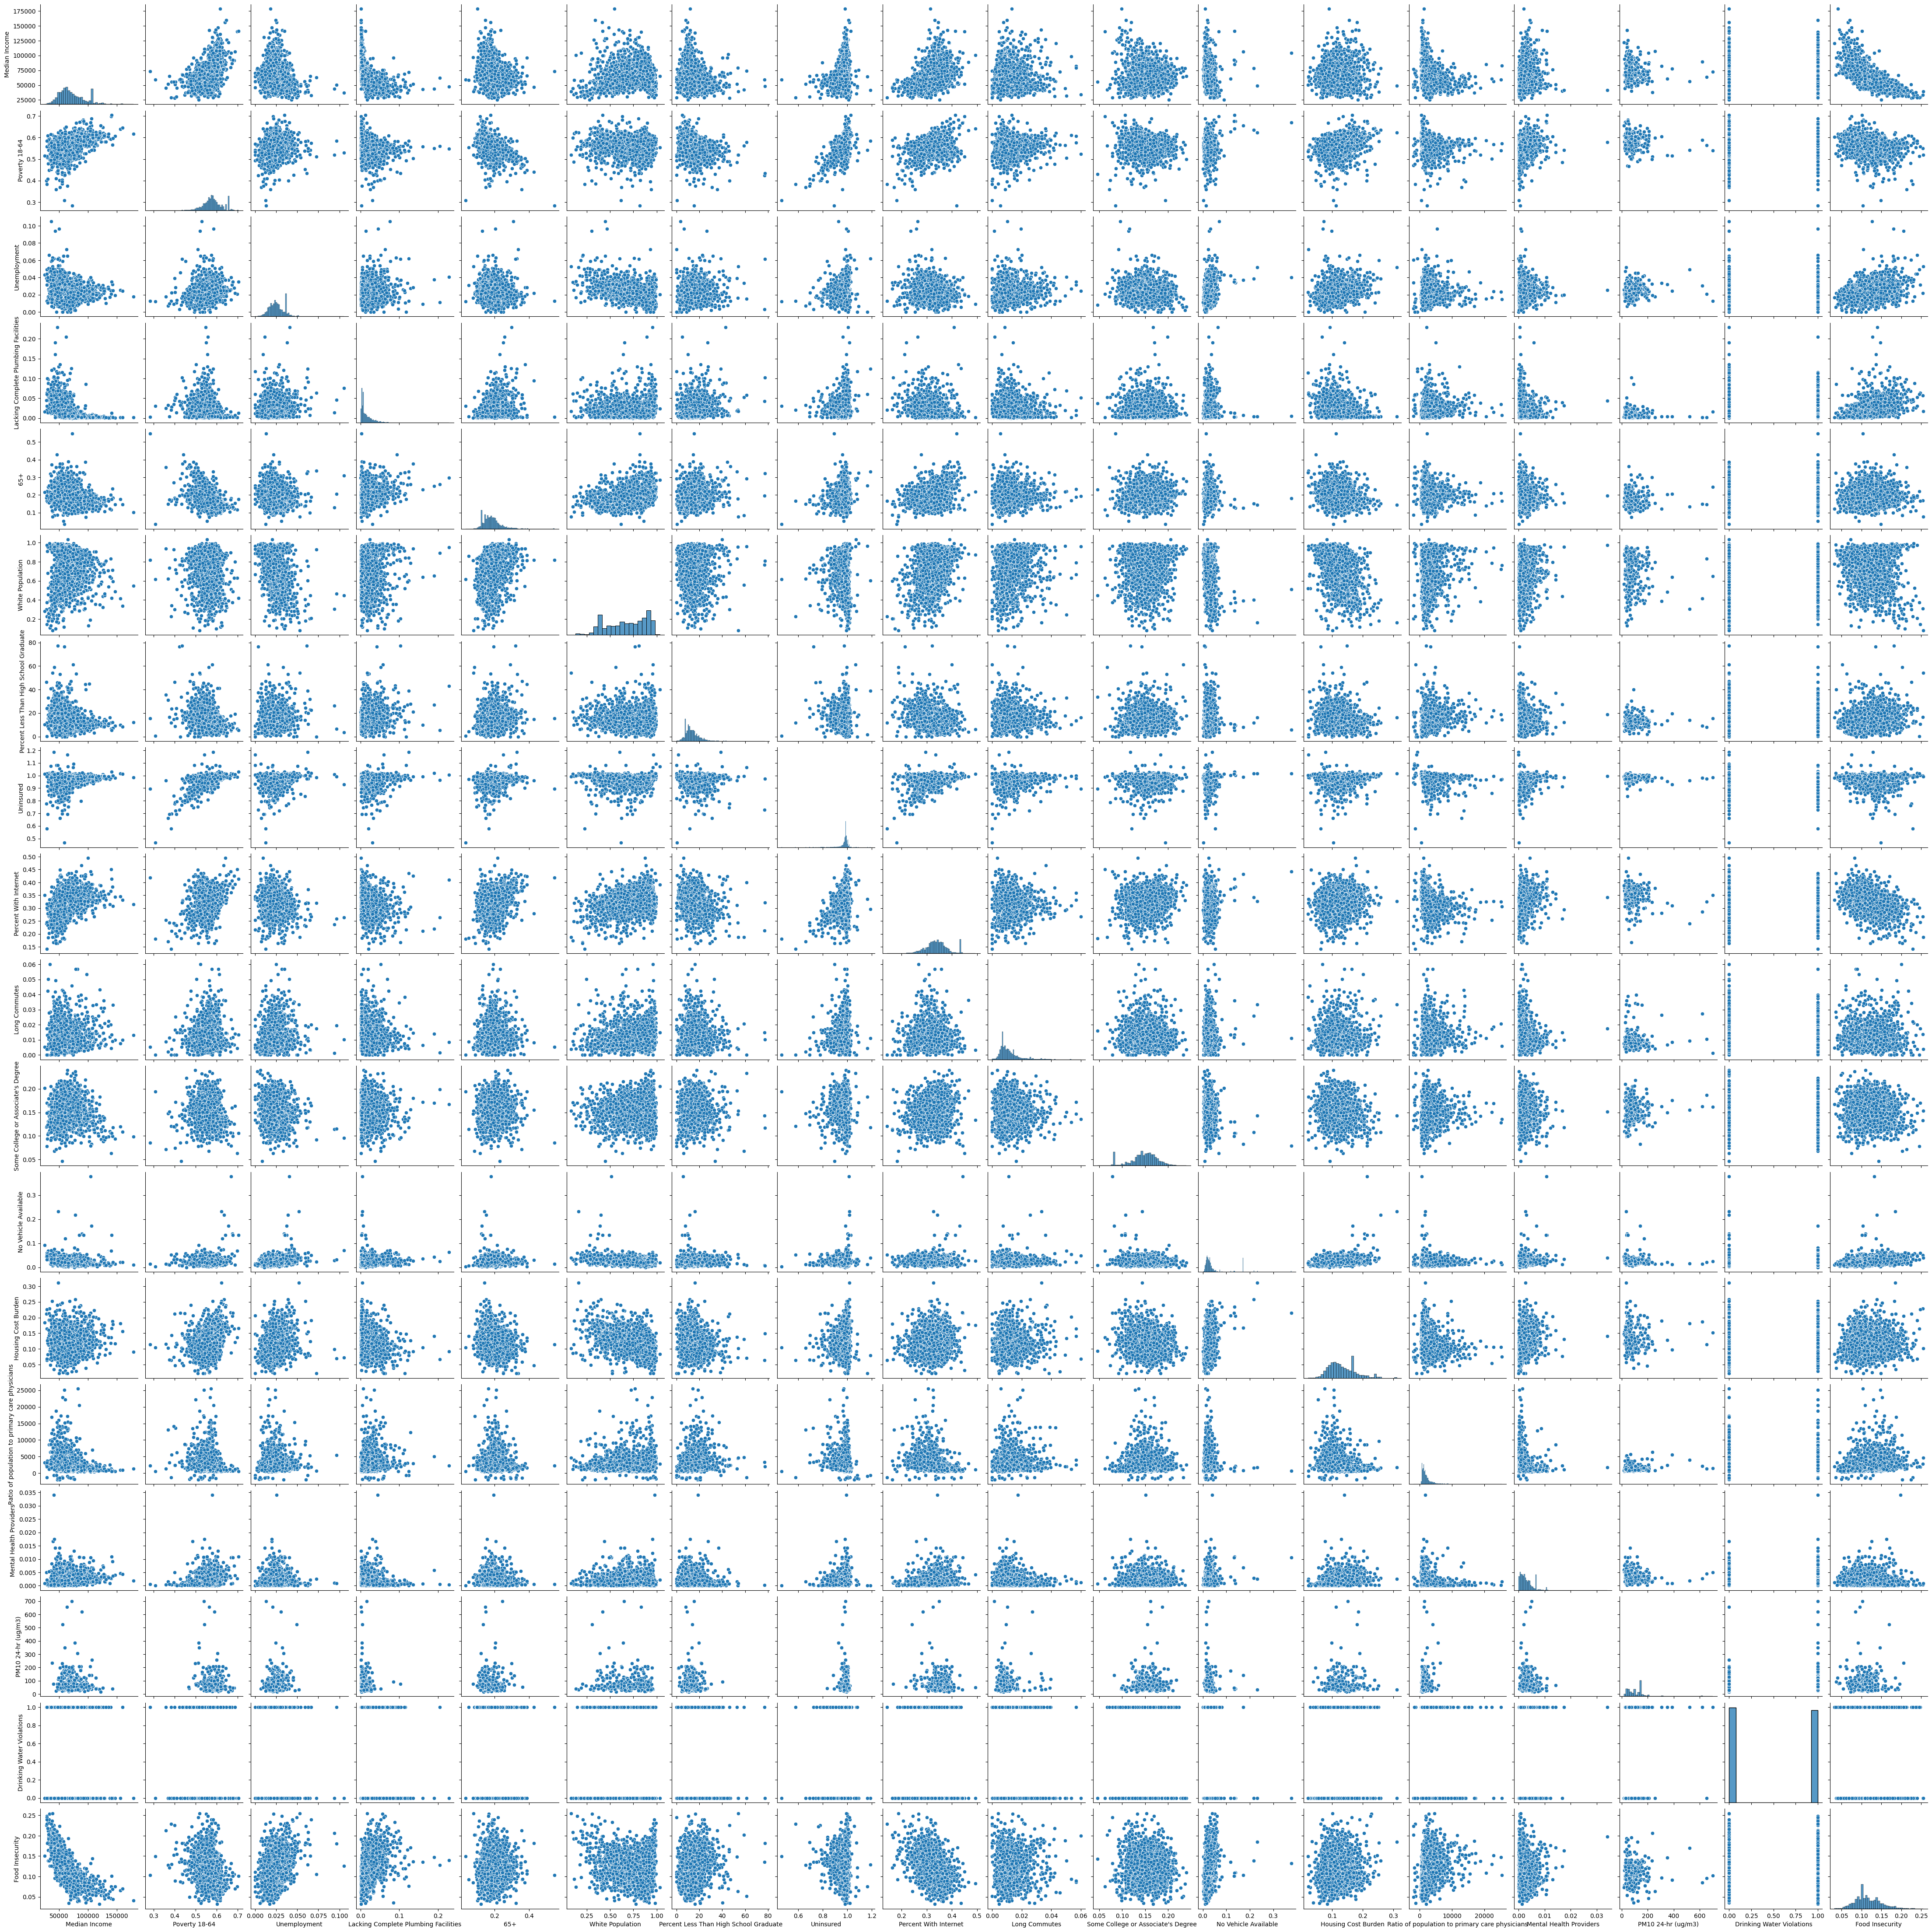

In [17]:
sns.pairplot(SDOH_df[SDOH_variables])  # Plot pairwise relationships
plt.show()

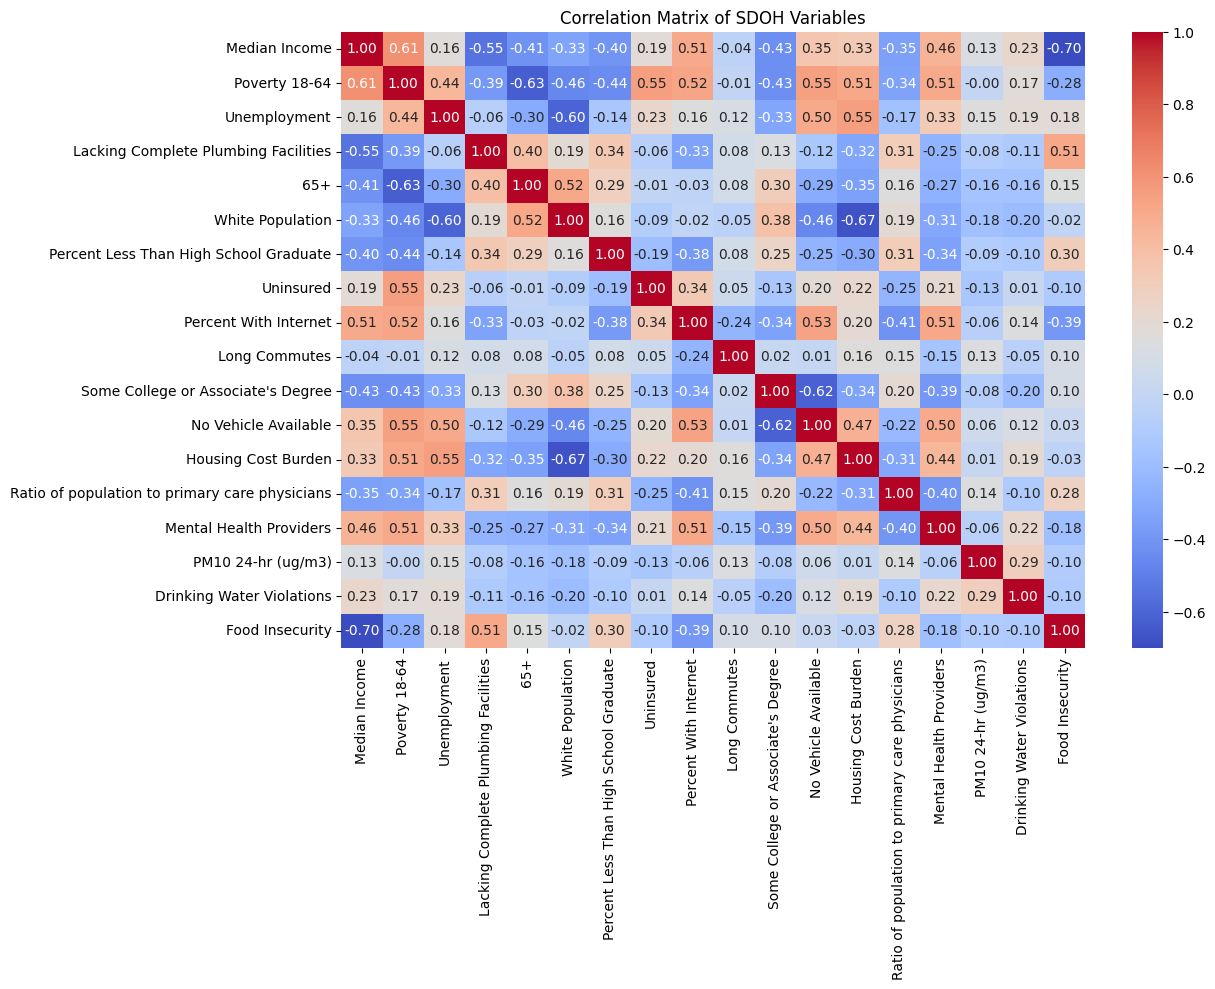

In [18]:
corr_matrix = SDOH_df[SDOH_variables].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of SDOH Variables')
plt.show()

## PCA

In [20]:
scalar = StandardScaler()
scaled_SDOH = scalar.fit_transform(normalized_SDOH_df[SDOH_variables])

pca = PCA(n_components=18)
pca_result = pca.fit_transform(scaled_SDOH)

for i in range(1, 19):
    normalized_SDOH_df[f'PCA{i}'] = pca_result[:, i - 1]



print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.31763314 0.12629042 0.10270215 0.06815568 0.06198832 0.05144392
 0.04912572 0.04184844 0.03476247 0.02989411 0.02768329 0.02373416
 0.01938288 0.01374548 0.01124066 0.00956456 0.00731503 0.00348957]


### PCA Biplot

In [21]:
loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=SDOH_variables, index=[f'PCA{i}' for i in range(1, 19)])

print(loadings_df.iloc[:5, :])

      Median Income  Poverty 18-64  Unemployment  \
PCA1      -0.312793       0.356182      0.224612   
PCA2       0.216112       0.009118      0.387531   
PCA3      -0.232414      -0.035534     -0.137796   
PCA4       0.027388      -0.112244     -0.036054   
PCA5       0.095700      -0.177495     -0.000575   

      Lacking Complete Plumbing Facilities       65+  White Population  \
PCA1                             -0.222297  0.239198          0.253580   
PCA2                              0.236673  0.143858          0.373338   
PCA3                             -0.262348  0.271642          0.074694   
PCA4                              0.305865 -0.237991         -0.177399   
PCA5                             -0.121689  0.264620          0.210663   

      Percent Less Than High School Graduate  Uninsured  \
PCA1                                0.228296  -0.162802   
PCA2                               -0.137731   0.073246   
PCA3                                0.135572   0.308297   
PCA4  

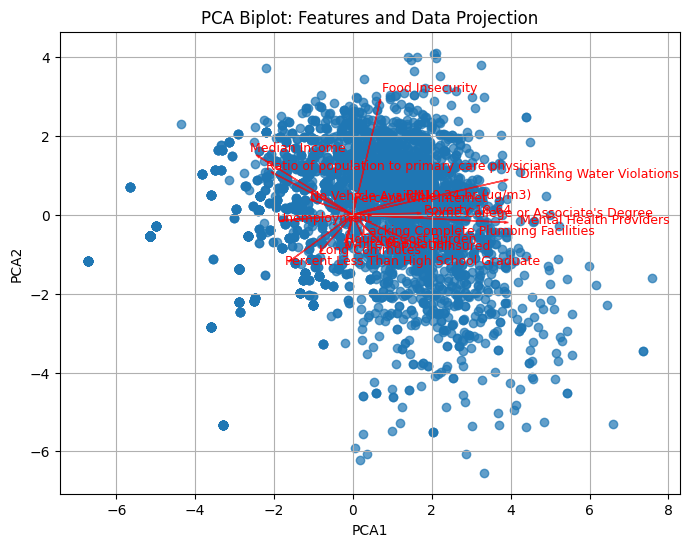

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(normalized_SDOH_df['PCA1'], normalized_SDOH_df['PCA2'], alpha=0.7)

# Plot the loadings (arrows) for the first two principal components
for i, feature in enumerate(SDOH_variables):
    plt.arrow(0, 0, loadings[i, 0]*max(normalized_SDOH_df['PCA1']), loadings[i, 1]*max(normalized_SDOH_df['PCA2']),
              color='r', alpha=0.7, head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0]*max(normalized_SDOH_df['PCA1']) * 1.1, loadings[i, 1]*max(normalized_SDOH_df['PCA2']) * 1.1,
             feature, color='r', fontsize=9)

plt.title('PCA Biplot: Features and Data Projection')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

### PCA Cumulative Variance Plot

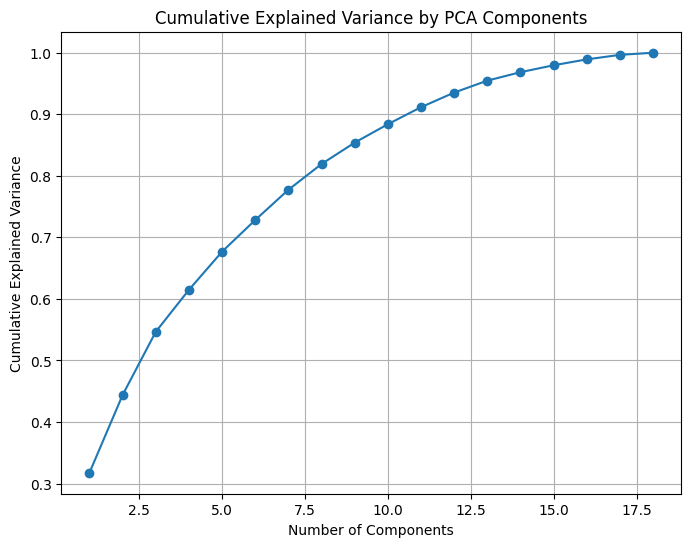

In [23]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, 19), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

### PCA State Grouped Plot

In [24]:
normalized_SDOH_df['State_Label'] = pd.factorize(normalized_SDOH_df['State'])[0]

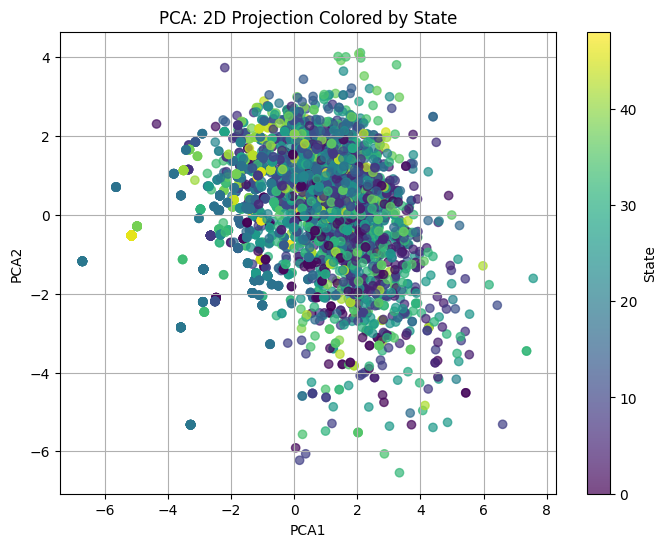

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(normalized_SDOH_df['PCA1'], normalized_SDOH_df['PCA2'], c=normalized_SDOH_df['State_Label'], cmap='viridis', alpha=0.7)
plt.title('PCA: 2D Projection Colored by State')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='State')  # Add a colorbar to indicate the regions
plt.grid(True)
plt.show()

# Modeling

## Data Splitting

In [26]:
merged_df = normalized_SDOH_df.join(outcome_df[outcome_variables])
merged_df.head()

Name          GEO_ID           State  \
0  Abbeville County, South Carolina  0500000US45001  South Carolina   
1          Acadia Parish, Louisiana  0500000US22001       Louisiana   
2         Accomack County, Virginia  0500000US51001        Virginia   
3                 Ada County, Idaho  0500000US16001           Idaho   
4                 Ada County, Idaho  0500000US16001           Idaho   

  Complete County Name State Abbreviation Health Center Number  \
0     Abbeville County                 SC           H80CS00785   
1        Acadia Parish                 LA           H80CS00558   
2      Accomack County                 VA           H80CS00791   
3           Ada County                 ID           H80CS00636   
4           Ada County                 ID           H80CS26601   

  County Equivalent Name  HHS Region Code HHS Region Name  \
0              Abbeville                4        Region 4   
1                 Acadia                6        Region 6   
2               Accomack                3        Region 3   
3                    Ada               10       Region 10   
4                    Ada               10       Region 10   

   State FIPS and Congressional District Number Code  ...     PCA15     PCA16  \
0                                               4503  ... -0.267835  0.295735   
1                                               2203  ... -0.246622  0.112814   
2                                               5102  ... -0.149270 -0.296530   
3                                               1602  ... -0.129490  0.104355   
4                                               1602  ... -0.129490  0.104355   

      PCA17     PCA18  State_Label  Premature Mortality  Infant Mortality  \
0 -0.551205 -0.179570            0           564.941382               NaN   
1 -0.091744 -0.089931            1           652.056300          5.812023   
2 -0.457679  0.089372            2           536.960650          9.471192   
3 -0.159264  0.132982            3           269.641981          4.515387   
4 -0.159264  0.132982            3           269.641981          4.515387   

   Preventable Hospital Stays  Heart Disease Mortality  Poor or Fair Health  
0                      2519.0                    354.9                0.200  
1                      3536.0                    538.4                0.224  
2                      2002.0                    421.9                0.205  
3                      1316.0                    269.5                0.115  
4                      1316.0                    269.5                0.115  

[5 rows x 53 columns]

In [27]:
outcome_imputed_df[outcome_variables]

Premature Mortality  Infant Mortality  Preventable Hospital Stays  \
0              564.941382          7.526696                      2519.0   
1              652.056300          5.812023                      3536.0   
2              536.960650          9.471192                      2002.0   
3              269.641981          4.515387                      1316.0   
4              269.641981          4.515387                      1316.0   
...                   ...               ...                         ...   
3902           487.413516          7.105231                      3939.0   
3903           464.510863          5.942112                      2180.0   
3904           464.510863          5.942112                      2180.0   
3905           502.735785          6.756599                      5293.0   
3906           653.844474          7.892189                      1884.0   

      Heart Disease Mortality  Poor or Fair Health  
0                       354.9                0.200  
1                       538.4                0.224  
2                       421.9                0.205  
3                       269.5                0.115  
4                       269.5                0.115  
...                       ...                  ...  
3902                    351.9                0.189  
3903                    273.3                0.224  
3904                    273.3                0.224  
3905                    298.8                0.330  
3906                    411.2                0.327  

[3907 rows x 5 columns]

In [28]:
X = normalized_SDOH_df[SDOH_variables]
y = outcome_imputed_df[outcome_variables]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Plot Outcomes Function

In [39]:
def plot_outcomes(X, y, y_test, y_pred):
    plt.figure(figsize=(8, 6))
    for i, outcome in enumerate(y.columns):
        plt.subplot(2, 3, i + 1)  # Adjust the layout for all subplots
        plt.scatter(y_test[outcome], y_pred[:, i])
        plt.plot([min(y_test[outcome]), max(y_test[outcome])], [min(y_test[outcome]), max(y_test[outcome])], color='red')  # Line of perfect prediction
        plt.title(f'{outcome} (R² = {r2_score(y_test[outcome], y_pred[:, i]):.2f})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

## Models

### Simple Linear Regression

In [31]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

y_pred_lr = lr_model.predict(X_test)
r_squared_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"R-squared: {r_squared_lr:.3f}")
print(f"Mean Squared Error: {mse_lr:.3f}")

R-squared: 0.563
Mean Squared Error: 149292.685


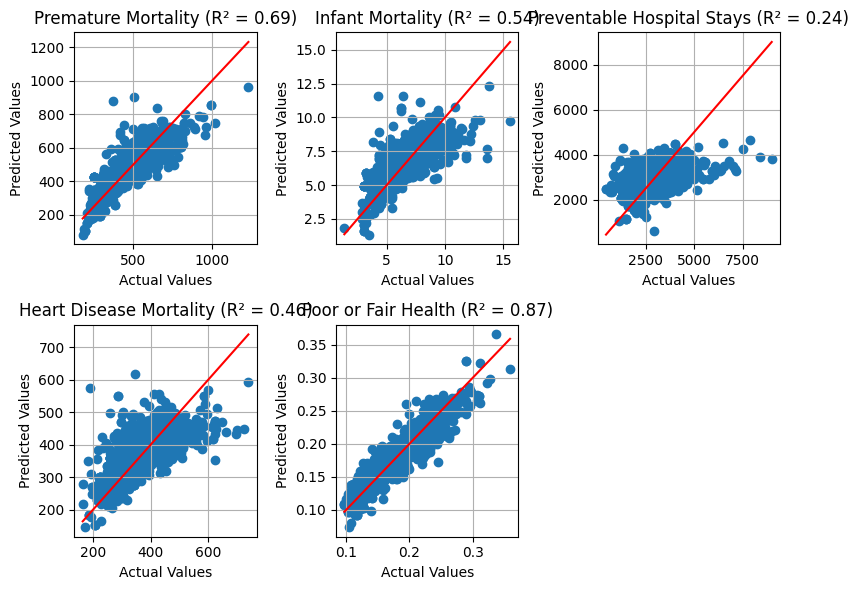

In [32]:
plot_outcomes(X, y, y_test, y_pred_lr)

### Random Forest

In [33]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=   7.2s
[CV] END max_depth=10, min_samples_split=2, n_e

In [34]:
importance_rf = best_rf_model.feature_importances_
print(f"Feature Importances: {importance_rf}")
y_pred_rf = best_rf_model.predict(X_test)

r_squared_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"R-squared: {r_squared_rf:.3f}")
print(f"Mean Squared Error: {mse_rf:.3f}")

Feature Importances: [0.06117325 0.04167015 0.0341749  0.0542323  0.07643802 0.09924459
 0.03550882 0.03901601 0.04482393 0.04330464 0.03430873 0.08933561
 0.03100267 0.04475035 0.06754988 0.04095506 0.00686951 0.15564159]
R-squared: 0.740
Mean Squared Error: 89541.498


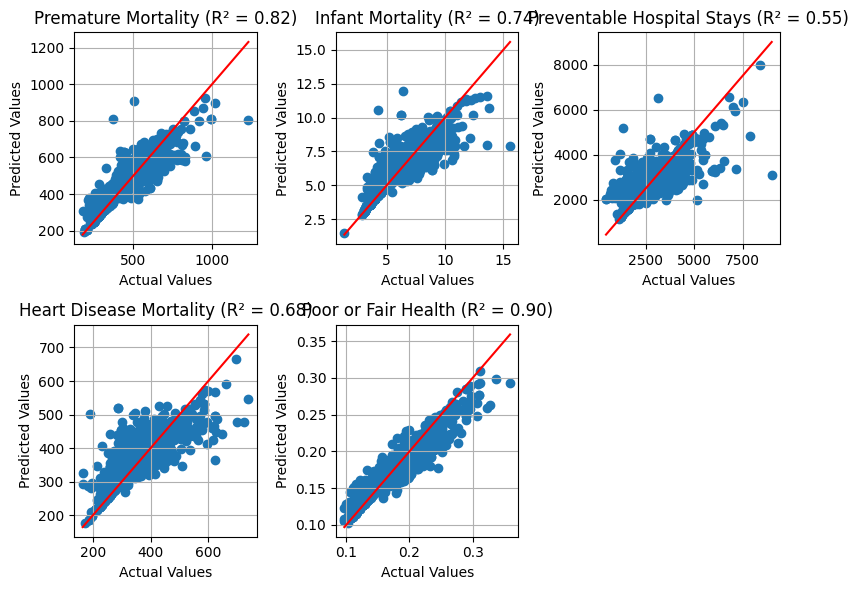

In [35]:
plot_outcomes(X, y, y_test, y_pred_rf)

### Gradient Boosting

In [36]:
gb_regressor = GradientBoostingRegressor()
multi_output_regressor = MultiOutputRegressor(gb_regressor)


# Define the hyperparameter grid
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__subsample': [0.8, 1.0],
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=multi_output_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
best_gb_model = grid_search.best_estimator_

with open('gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(best_gb_model, file)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=100, estimator__subsample=0.8; total time=   5.3s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=100, estimator__subsample=0.8; total time=   5.4s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=100, estimator__subsample=0.8; total time=   5.4s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=100, estimator__subsample=1.0; total time=   5.8s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=100, estimator__subsample=1.0; total time=   5.8s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_

In [37]:
y_pred_gb = best_gb_model.predict(X_test)

r_squared_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"R-squared: {r_squared_gb:.3f}")
print(f"Mean Squared Error: {mse_gb:.3f}")

R-squared: 0.752
Mean Squared Error: 93920.803


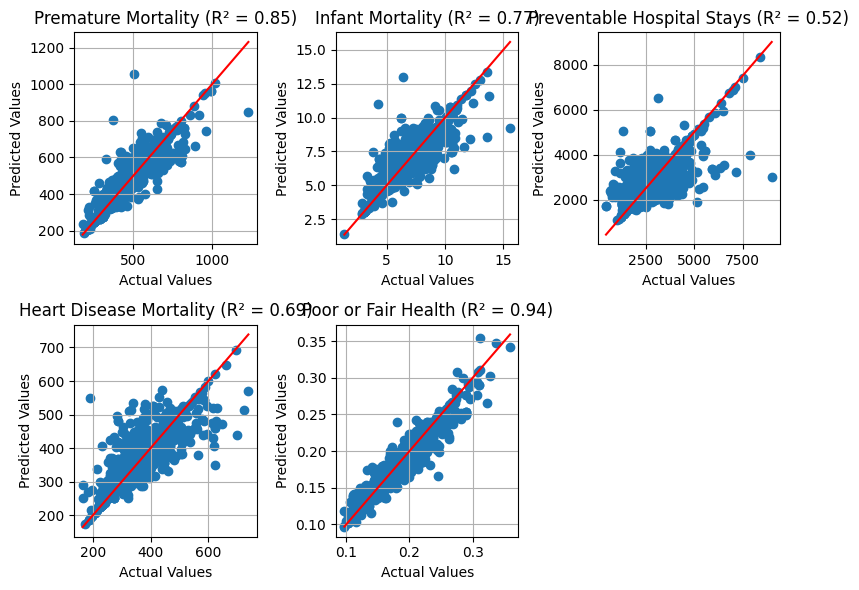

In [38]:
plot_outcomes(X, y, y_test, y_pred_gb)

### XGBoost

In [40]:
xgb_regressor = xg.XGBRegressor()
multi_output_regressor = MultiOutputRegressor(xgb_regressor)

# Define the hyperparameter grid
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.8, 1.0],
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=multi_output_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
best_xgb_model = grid_search.best_estimator_

with open('xg_boosting_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=0.8; total time=   5.2s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=0.8; total time=   5.4s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   5.4s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   5.4s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=0.8; total time=   5.6s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   5.6s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   5.7s
[CV] END estimator__learning_rate=

In [41]:
y_pred_xgb = best_xgb_model.predict(X_test)

r_squared_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"R-squared: {r_squared_xgb:.3f}")
print(f"Mean Squared Error: {mse_xgb:.3f}")

R-squared: 0.760
Mean Squared Error: 87754.508


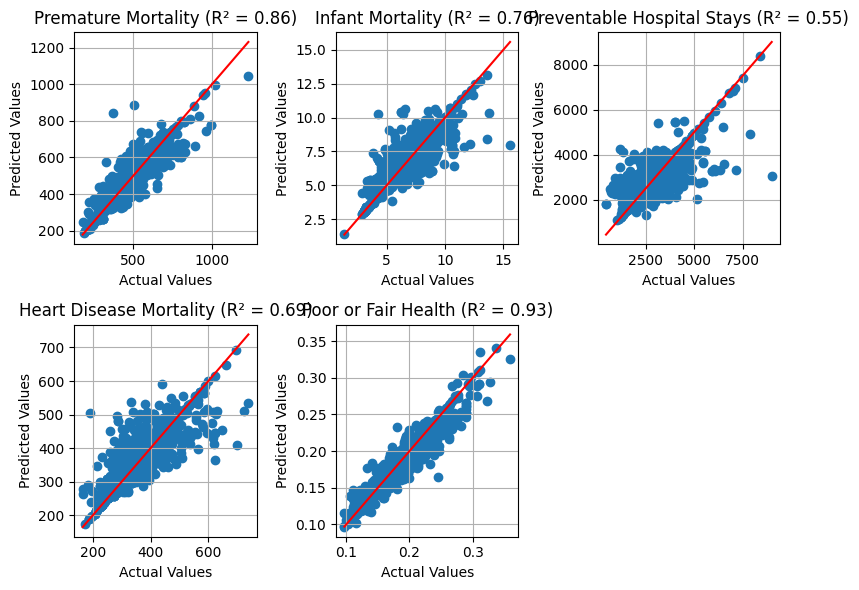

In [42]:
plot_outcomes(X, y, y_test, y_pred_xgb)

### Neural Network

In [29]:
def create_model(optimizer='adam', init='glorot_uniform', neurons=64):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Use Input layer to specify input shape
    model.add(Dense(neurons, activation='relu', kernel_initializer=init))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(outcome_variables)))  # Multi-output regression

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn=None, optimizer='adam', init='glorot_uniform', neurons=64, epochs=100, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.init = init
        self.neurons = neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = self.build_fn(optimizer=self.optimizer, init=self.init, neurons=self.neurons)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, validation_split=0.2, callbacks=[early_stopping])
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
model = KerasRegressorWrapper(build_fn=create_model, verbose=2)

param_grid = {
    'neurons': [32, 64, 128],  # Number of neurons in the first hidden layer
    'optimizer': ['adam', 'sgd'],  # Optimizer to use
    'batch_size': [16, 32],  # Batch size for training
    'epochs': [50, 100],  # Number of epochs for training
    'init': ['glorot_uniform', 'normal']  # Weight initialization methods
}

try:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        grid_result = grid.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_result.best_params_}")
    best_model_keras = grid_result.best_estimator_
    best_model_keras.model.save('keras_model.h5'))
except Exception as e:
    print(f"An error occurred: {e}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits


E0000 00:00:1742154782.081685 1003152 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1742154782.085661 1003152 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
114/114 - 1s - 11ms/step - loss: 1937752.6250 - mae: 739.6931
Epoch 2/50
114/114 - 0s - 2ms/step - loss: 1293750.1250 - mae: 539.0714
Epoch 3/50
114/114 - 0s - 2ms/step - loss: 300671.8125 - mae: 240.5256
Epoch 4/50
114/114 - 0s - 2ms/step - loss: 235966.0469 - mae: 199.2536
Epoch 5/50
114/114 - 0s - 2ms/step - loss: 233785.6719 - mae: 197.8175
Epoch 6/50
114/114 - 0s - 2ms/step - loss: 231449.8594 - mae: 196.6510
Epoch 7/50
114/114 - 0s - 2ms/step - loss: 231119.8281 - mae: 196.1892
Epoch 8/50
114/114 - 0s - 2ms/step - loss: 227289.4688 - mae: 194.3053
Epoch 9/50
114/114 - 0s - 2ms/step - loss: 224969.0625 - mae: 192.6967
Epoch 10/50
114/114 - 0s - 2ms/step - loss: 222765.1406 - mae: 191.2349
Epoch 11/50
114/114 - 0s - 2ms/step - loss: 221315.0938 - mae: 190.7604
Epoch 12/50
114/114 - 0s - 2ms/step - loss: 219035.0469 - mae: 189.0967
Epoch 13/50
114/114 - 0s - 2ms/step - loss: 216199.1719 - mae: 187.3913
Epoch 14/50
114/114 - 0s - 2ms/step - loss: 213922.8750 - mae: 186.709

/home/apurv/Github/RADI/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/apurv/Github/RADI/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


57/57 - 1s - 20ms/step - loss: 1963250.0000 - mae: 747.3286
Epoch 2/50
57/57 - 0s - 3ms/step - loss: 1935895.1250 - mae: 739.4456
Epoch 3/50
57/57 - 0s - 2ms/step - loss: 1760023.6250 - mae: 681.2390
Epoch 4/50
57/57 - 0s - 3ms/step - loss: 1255230.3750 - mae: 512.7453
Epoch 5/50
57/57 - 0s - 2ms/step - loss: 597461.1250 - mae: 351.6569
Epoch 6/50
57/57 - 0s - 2ms/step - loss: 266064.9375 - mae: 216.9195
Epoch 7/50
57/57 - 0s - 2ms/step - loss: 236895.6875 - mae: 199.3334
Epoch 8/50
57/57 - 0s - 2ms/step - loss: 236215.7344 - mae: 199.4937
Epoch 9/50
57/57 - 0s - 2ms/step - loss: 235447.2188 - mae: 198.4661
Epoch 10/50
57/57 - 0s - 3ms/step - loss: 234845.3594 - mae: 198.5697
Epoch 11/50
57/57 - 0s - 2ms/step - loss: 234157.5312 - mae: 198.0594
Epoch 12/50
57/57 - 0s - 2ms/step - loss: 232879.5156 - mae: 197.2763
Epoch 13/50
57/57 - 0s - 2ms/step - loss: 232174.8594 - mae: 196.6203
Epoch 14/50
57/57 - 0s - 2ms/step - loss: 231381.7656 - mae: 196.5708
Epoch 15/50
57/57 - 0s - 2ms/step -

In [33]:
best_model_keras.model.save('keras_model.keras')

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_model_keras.model.fit(X_train, y_train, epochs=500, batch_size=best_model_keras.batch_size, verbose=2, validation_split=0.2, callbacks=[early_stopping])

best_model_keras.model.save('keras_model_final.keras')

Epoch 1/500
137/137 - 1s - 4ms/step - loss: 166860.5781 - mae: 155.2151 - val_loss: 173037.9844 - val_mae: 154.5683
Epoch 2/500
137/137 - 0s - 3ms/step - loss: 167209.3438 - mae: 155.1898 - val_loss: 173196.4531 - val_mae: 154.5669
Epoch 3/500
137/137 - 0s - 3ms/step - loss: 166694.7031 - mae: 155.6185 - val_loss: 176778.8125 - val_mae: 157.3740
Epoch 4/500
137/137 - 0s - 3ms/step - loss: 167568.4062 - mae: 155.9388 - val_loss: 173988.0938 - val_mae: 157.2246
Epoch 5/500
137/137 - 0s - 3ms/step - loss: 167766.5938 - mae: 156.1667 - val_loss: 173790.5938 - val_mae: 155.1346
Epoch 6/500
137/137 - 0s - 3ms/step - loss: 166915.0781 - mae: 155.2996 - val_loss: 173604.1094 - val_mae: 155.9459
Epoch 7/500
137/137 - 0s - 3ms/step - loss: 166820.3594 - mae: 155.4234 - val_loss: 176647.7812 - val_mae: 159.0830
Epoch 8/500
137/137 - 0s - 2ms/step - loss: 166452.7812 - mae: 155.3546 - val_loss: 173510.6562 - val_mae: 154.7835
Epoch 9/500
137/137 - 0s - 2ms/step - loss: 166587.8281 - mae: 154.9370 

In [36]:
y_pred_keras = best_model_keras.predict(X_test)

r_squared_keras = r2_score(y_test, y_pred_keras)
mse_keras = mean_squared_error(y_test, y_pred_keras)

print(f"R-squared: {r_squared_keras:.3f}")
print(f"Mean Squared Error: {mse_keras:.3f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R-squared: -7.831
Mean Squared Error: 157706.438


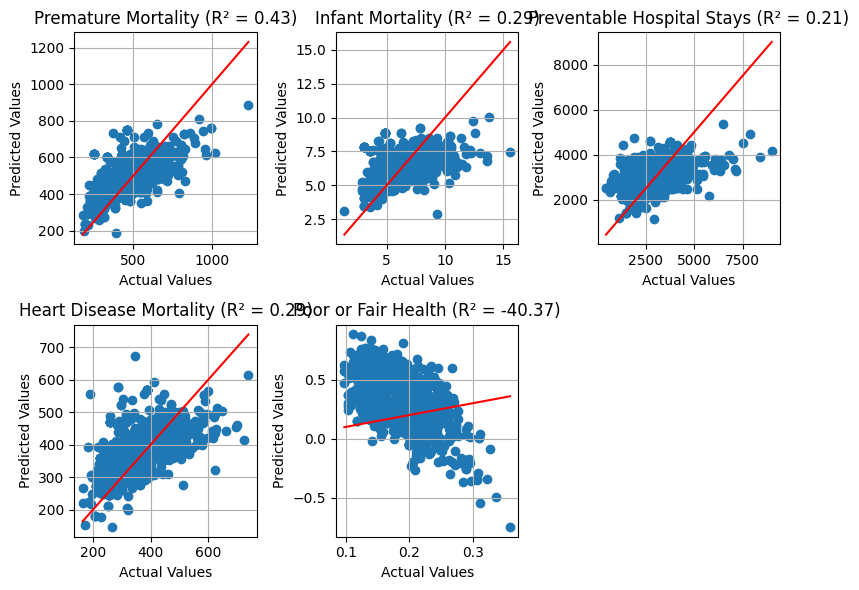

In [40]:
plot_outcomes(X, y, y_test, y_pred_keras)

## Best Model: XGBoost

In [41]:
with open('xg_boosting_model.pkl', 'rb') as file:
    loaded_xgb_model = pickle.load(file)

### Use Model to Predict All Counties

In [57]:
X_all = normalized_SDOH_df[SDOH_variables]
y_pred_all = loaded_xgb_model.predict(X_all)

y_pred_df = pd.DataFrame(y_pred_all, columns=outcome_variables)
normalized_SDOH_df[outcome_variables] = y_pred_df

### Normalize Predictions

In [ ]:
for outcome in outcome_variables:
    min_val = y_pred_df[outcome].min()
    max_val = y_pred_df[outcome].max()
    normalized_SDOH_df[outcome + '_normalized'] = (y_pred_df[outcome] - min_val) / (max_val - min_val) * 100

In [59]:
normalized_SDOH_df['SDOH_subindex'] = normalized_SDOH_df[SDOH_variables].mean(axis=1)

min_sdo = normalized_SDOH_df['SDOH_subindex'].min()
max_sdo = normalized_SDOH_df['SDOH_subindex'].max()
normalized_SDOH_df['SDOH_subindex_normalized'] = (normalized_SDOH_df['SDOH_subindex'] - min_sdo) / (max_sdo - min_sdo) * 100

# EASHWAR IDK HOW TO CALCULATE RADI SCORE

### Calculate RADI Score

In [60]:
normalized_SDOH_df['RADI_score'] = (
    # normalized_SDOH_df['SDOH_subindex_normalized'] +
    normalized_SDOH_df['Premature Mortality_normalized'] +
    normalized_SDOH_df['Infant Mortality_normalized'] +
    normalized_SDOH_df['Preventable Hospital Stays_normalized'] +
    normalized_SDOH_df['Heart Disease Mortality_normalized'] +
    normalized_SDOH_df['Poor or Fair Health_normalized']
) / 5

### Create Equal Interval RADI Tiers

In [61]:
bins = np.linspace(0, 100, 10)
labels = [f'Tier {i}' for i in range(1, 10)]
radi_tiers = pd.cut(normalized_SDOH_df['RADI_score'], bins=bins, labels=labels, right=False)
normalized_SDOH_df['RADI_tiers'] = radi_tiers
print(normalized_SDOH_df[['Complete County Name', 'RADI_score', 'RADI_tiers']].head())

  Complete County Name  RADI_score RADI_tiers
0     Abbeville County   30.597193     Tier 3
1        Acadia Parish   38.648308     Tier 4
2      Accomack County   32.533264     Tier 3
3           Ada County   13.769293     Tier 2
4           Ada County   13.769293     Tier 2


### Check Distribution of Tiers

In [69]:
normalized_SDOH_df['RADI_tiers'].value_counts()

RADI_tiers
Tier 3    1923
Tier 2    1069
Tier 4     740
Tier 5     122
Tier 1      33
Tier 6      19
Tier 8       1
Tier 7       0
Tier 9       0
Name: count, dtype: int64

### Compare with RUCC

In [62]:
rucc_df = pd.read_csv(processed_data_path + 'rucc.csv', encoding='latin-1')
rucc_df

FIPS State        County_Name  Attribute  Value
0      1001    AL     Autauga County  RUCC_2023      2
1      1003    AL     Baldwin County  RUCC_2023      3
2      1005    AL     Barbour County  RUCC_2023      6
3      1007    AL        Bibb County  RUCC_2023      1
4      1009    AL      Blount County  RUCC_2023      1
...     ...   ...                ...        ...    ...
3228  72151    PR  Yabucoa Municipio  RUCC_2023      1
3229  72153    PR    Yauco Municipio  RUCC_2023      2
3230  78010    VI   St. Croix Island  RUCC_2023      5
3231  78020    VI    St. John Island  RUCC_2023      9
3232  78030    VI  St. Thomas Island  RUCC_2023      5

[3233 rows x 5 columns]

In [63]:
rucc_df = rucc_df.rename(columns={'Value': 'RUCC_2023', 'County_Name': 'Complete County Name', 'FIPS': '5-digit FIPS Code',
                                  'State': 'State Abbreviation'})
rucc_df = rucc_df[['5-digit FIPS Code', 'State Abbreviation', 'Complete County Name', 'RUCC_2023']]
rucc_df

5-digit FIPS Code State Abbreviation Complete County Name  RUCC_2023
0                  1001                 AL       Autauga County          2
1                  1003                 AL       Baldwin County          3
2                  1005                 AL       Barbour County          6
3                  1007                 AL          Bibb County          1
4                  1009                 AL        Blount County          1
...                 ...                ...                  ...        ...
3228              72151                 PR    Yabucoa Municipio          1
3229              72153                 PR      Yauco Municipio          2
3230              78010                 VI     St. Croix Island          5
3231              78020                 VI      St. John Island          9
3232              78030                 VI    St. Thomas Island          5

[3233 rows x 4 columns]

In [64]:
radi_rucc_df = pd.merge(normalized_SDOH_df, rucc_df[['State Abbreviation', 'Complete County Name', 'RUCC_2023']], 
                        on=['Complete County Name', 'State Abbreviation'], how='inner')
radi_rucc_df

Name          GEO_ID           State  \
0     Abbeville County, South Carolina  0500000US45001  South Carolina   
1             Acadia Parish, Louisiana  0500000US22001       Louisiana   
2            Accomack County, Virginia  0500000US51001        Virginia   
3                    Ada County, Idaho  0500000US16001           Idaho   
4                    Ada County, Idaho  0500000US16001           Idaho   
...                                ...             ...             ...   
3902           Yuba County, California  0500000US06115      California   
3903              Yuma County, Arizona  0500000US04027         Arizona   
3904              Yuma County, Arizona  0500000US04027         Arizona   
3905              Zapata County, Texas  0500000US48505           Texas   
3906              Zavala County, Texas  0500000US48507           Texas   

     Complete County Name State Abbreviation Health Center Number  \
0        Abbeville County                 SC           H80CS00785   
1           Acadia Parish                 LA           H80CS00558   
2         Accomack County                 VA           H80CS00791   
3              Ada County                 ID           H80CS00636   
4              Ada County                 ID           H80CS26601   
...                   ...                ...                  ...   
3902          Yuba County                 CA           H80CS08234   
3903          Yuma County                 AZ           H80CS04321   
3904          Yuma County                 AZ           H80CS26606   
3905        Zapata County                 TX           H80CS00779   
3906        Zavala County                 TX           H80CS00375   

     County Equivalent Name  HHS Region Code HHS Region Name  \
0                 Abbeville                4        Region 4   
1                    Acadia                6        Region 6   
2                  Accomack                3        Region 3   
3                       Ada               10       Region 10   
4                       Ada               10       Region 10   
...                     ...              ...             ...   
3902                   Yuba                9        Region 9   
3903                   Yuma                9        Region 9   
3904                   Yuma                9        Region 9   
3905                 Zapata                6        Region 6   
3906                 Zavala                6        Region 6   

      State FIPS and Congressional District Number Code  ...  \
0                                                  4503  ...   
1                                                  2203  ...   
2                                                  5102  ...   
3                                                  1602  ...   
4                                                  1602  ...   
...                                                 ...  ...   
3902                                                603  ...   
3903                                                407  ...   
3904                                                407  ...   
3905                                               4828  ...   
3906                                               4823  ...   

      Poor or Fair Health  Premature Mortality_normalized  \
0                0.201650                       26.277065   
1                0.226167                       31.799593   
2                0.202010                       24.601196   
3                0.114869                        8.827692   
4                0.114869                        8.827692   
...                   ...                             ...   
3902             0.188141                       21.459208   
3903             0.222930                       20.745527   
3904             0.222930                       20.745527   
3905             0.330915                       22.913294   
3906             0.294412                       33.799805   

      Infant Mortality_normalized  Preventabl

In [66]:
radi_rucc_df = radi_rucc_df[['Complete County Name', 'State Abbreviation', 'RUCC_2023', 'RADI_score', 'RADI_tiers']]
radi_rucc_df

Complete County Name State Abbreviation  RUCC_2023  RADI_score RADI_tiers
0        Abbeville County                 SC          6   30.597193     Tier 3
1           Acadia Parish                 LA          2   38.648308     Tier 4
2         Accomack County                 VA          9   32.533264     Tier 3
3              Ada County                 ID          2   13.769293     Tier 2
4              Ada County                 ID          2   13.769293     Tier 2
...                   ...                ...        ...         ...        ...
3902          Yuba County                 CA          3   30.477283     Tier 3
3903          Yuma County                 AZ          3   26.961117     Tier 3
3904          Yuma County                 AZ          3   26.961117     Tier 3
3905        Zapata County                 TX          6   41.515266     Tier 4
3906        Zavala County                 TX          7   44.159580     Tier 4

[3907 rows x 5 columns]

In [67]:
radi_rucc_df.to_csv(processed_data_path + 'radi_rucc.csv', index=False)

In [68]:
radi_rucc_df.sort_values(by='RADI_score', ascending=False).head(10)

Complete County Name State Abbreviation  RUCC_2023  RADI_score RADI_tiers
352        Buffalo County                 SD          9   82.520042     Tier 8
2476         Mingo County                 WV          8   66.155975     Tier 6
2477         Mingo County                 WV          8   66.155975     Tier 6
2478         Mingo County                 WV          8   66.155975     Tier 6
2850         Perry County                 KY          7   65.156616     Tier 6
2849         Perry County                 KY          7   65.156616     Tier 6
2848         Perry County                 KY          7   65.156616     Tier 6
1203  East Carroll Parish                 LA          8   64.161179     Tier 6
1550        Harlan County                 KY          7   62.552998     Tier 6
1551        Harlan County                 KY          7   62.552998     Tier 6